In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'aa203/ps2/code/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/aa203/ps2/code


In [ ]:
!python problem2_ilqr_starter.py

Computing iLQR solution ... 2021-05-05 21:39:26.165848: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
done! (3.36 s)
Simulating ...done! (0.25 s)
<Figure size 1200x200 with 4 Axes>
<Figure size 640x480 with 1 Axes>


In [ ]:
!python problem3_scp_starter.py

2021-05-05 21:46:47.458674: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Computing SCP solution ... round: 0, u update: 0.5000007213824531
round: 1, u update: 0.5000007202098382
Traceback (most recent call last):
  File "problem3_scp_starter.py", line 137, in <module>
    s,u = scp(f_discrete,Q,R,Qf,goal_state,start_state,N,dt,rho,uLB,uUB) # scp; yours to implement
  File "problem3_scp_starter.py", line 50, in scp
    s,u = scp_iteration(f,Q,R,Q_N,s_bar,u_bar,s_star,s0,N,dt,rho,uLB,uUB)
  File "problem3_scp_starter.py", line 83, in scp_iteration
    prob.solve()
  File "/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py", line 290, in solve
    return solve_func(self, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/cvxpy/problems/problem.py", line 570, in _solve
    self._intermediate_problem)
  File "/usr/local/lib/python3.7/dist-packages/cvxpy

In [ ]:
!python scp.py

2021-05-07 20:17:36.419181: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Computing SCP solution ... [0. 0.] 0.0
[40.  0.] 40.0
round: 0, u update: 1.1570799977304838
[0. 0.] 0.0
[40.  0.] 40.0
round: 1, u update: 1.3141590760681212
[0. 0.] 0.0
[40.  0.] 40.0
round: 2, u update: 0.5575507380092679
[0. 0.] 0.0
[40.  0.] 40.0
round: 3, u update: 0.22832521842759446
[0. 0.] 0.0
[40.  0.] 40.0
round: 4, u update: 0.029701661591021437
[0. 0.] 0.0
[40.  0.] 40.0
done!
Simulating ...
100% 99/99 [00:00<00:00, 5462.12it/s]
Traceback (most recent call last):
  File "scp.py", line 363, in <module>
    plt.set_xlabel(r'$x$')
AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'


In [ ]:
!python iLQR.py

Computing iLQR solution ... (2, 200, 5)
2021-05-06 22:03:09.335111: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
done! (0.46 s)
Simulating ...done! (0.04 s)
<Figure size 1000x2000 with 16 Axes>


In [ ]:
import numpy as np
from scipy.integrate import odeint
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxpy as cvx

In [ ]:
@jax.partial(jax.jit, static_argnums=(0,))
def linearize(f, x, u):
    ###########################################################################
    # WRITE YOUR CODE HERE
    A = jax.jacfwd(f, argnums=0)(x, u)
    B = jax.jacfwd(f, argnums=1)(x, u)
    c = f(x, u)
    ###########################################################################    
    return A, B, c

def scp(f,Q,R,Q_N,s_star,s0,N,dt,rho,UB,LB,vUB,omegaUB,case,agent):

    # Outer loop of scp.
    # Implement the inner loop in the function scp_iteration. 

    n = Q.shape[0] # state dimension
    m = R.shape[0] # control dimension
    eps = 0.01 # termination threshold for scp

    # initialize reference rollout s_bar,u_bar
    #u_bar = np.random.uniform(-3,3,(N,m))
    u_bar = np.zeros((agent,N,m))

    s_bar = np.zeros((agent,N+1,n))
    s_bar[:, 0] = s0
    for a in range(agent):
        for k in range(N):
            s_bar[a, k+1] = f(s_bar[a, k],u_bar[a, k])


    # Compute new state and control via scp.
    s, u = scp_iteration(f,Q,R,Q_N,s_bar,u_bar,s_star,s0,N,dt,rho,UB,LB,vUB,omegaUB,case,agent)

    # run scp until u converges
    round = 0
    err = 0
    for a in range(agent):
        err = max(err, np.linalg.norm(u[a]-u_bar[a],np.inf))
    while(err > eps and round < 20):
        print("round: %s, u update: %s" % (round, err))
        # print("u=", u_bar, "y=", s_bar[:, 1])
        round = round+1
        s_bar = s
        u_bar = u
        s,u = scp_iteration(f,Q,R,Q_N,s_bar,u_bar,s_star,s0,N,dt,rho,UB,LB,vUB,omegaUB,case,agent)
        err = 0
        for a in range(agent):
            err = max(err, np.linalg.norm(u[a]-u_bar[a],np.inf))

    
    return s,u


In [ ]:
def scp_iteration(f,Q,R,Q_N,s_bar,u_bar,s_star,s0,N,dt,rho,UB,LB,vUB,omegaUB,case,agent):

    ###########################################################################
    # WRITE YOUR CODE HERE
    # implement one iteration of scp
    # HINT: See slides 34-38 of Recitation 1. 
    t_in = np.zeros(agent)
    t_out = np.zeros(agent)
    s_all = np.zeros((s_bar.shape[0],s_bar.shape[1],s_bar.shape[2]))
    u_all = np.zeros((u_bar.shape[0],u_bar.shape[1],u_bar.shape[2]))
    for a in range(agent):
        print(t_in, np.max(t_in[:-1]))
        s = cvx.Variable(s_bar[a].shape)
        u = cvx.Variable(u_bar[a].shape)
        cost_terms = []
        constraints = []
        constraints.append(s[0] == s0[a])
        A, B, c = jax.vmap(linearize, in_axes=(None, 0, 0))(f, s_bar[a, :-1], u_bar[a])
        A, B, c = np.array(A), np.array(B), np.array(c)
        # D = np.diag(np.array([]))
        # print(A, B, c)
        for k in range(N):
            cost_terms.append(cvx.quad_form(s[k] - s_star[a], Q))
            cost_terms.append(cvx.quad_form(u[k], R))
            # if a > 0:
            #     for a_prev in range(a):
                    # cost_terms.append(cvx.quad_form(s[k, 0:2] - s_all[a_prev, k, 0:2], D))
            #         cost_terms.append(max(0, -cvx.log(0.2 + cvx.norm(s[k, 0:2] - s_all[a_prev, k, 0:2], "inf"))))
            # constraints.append(cvx.norm(s[k] - s_bar[k], "inf") <= rho)
            constraints.append(cvx.norm(u[k] - u_bar[a,k], "inf") <= 1)
            # if case[a] == 'upleft' and k <= N//3:
            #     constraints.append(s[k, 1] >= -1)
            #     constraints.append(s[k, 1] <= 1)
            # if case[a] == 'upleft' and k >= N//4:
            #     constraints.append(s[k, 0] >= -1)
            #     constraints.append(s[k, 0] <= 1)
            if case[a] == 'straight':
                if a == 0:
                    constraints.append(s[k, 0] >= -1)
                    constraints.append(s[k, 0] <= 1)
                if a == 1:
                    constraints.append(s[k, 1] >= -1)
                    constraints.append(s[k, 1] <= 1)
            if a > 0 and k <= np.max(t_in[:-1]):
                constraints.append(s[k, 0] <= -1)
                constraints.append(s[k, 1] <= 1)
                constraints.append(s[k, 1] >= -1)
            # if a > 0:
            #     for a_prev in range(a):
                    # continue
                    # constraints.append(-cvx.log(0.2 + cvx.norm(s[k, 0:2] - s_all[a_prev, k, 0:2], "inf")) <= 0)
                    # constraints.append(cvx.norm(s[k, 0:2] - s_all[a_prev, k, 0:2], "inf") <= 0.2)
            constraints.append(s[k, 3] <= 2)
            constraints.append(s[k, 3] >= 0)
            constraints.append(u[k, 0] <= vUB)
            constraints.append(u[k, 0] >= -vUB)
            constraints.append(u[k, 1] <= omegaUB)
            constraints.append(u[k, 1] >= -omegaUB)
            # constraints.append(cvx.norm(state1 @ s[k] - state2 @ s[k]) >= 0.5) 
            constraints.append(A[k] @ (s[k] - s_bar[a,k]) + B[k] @ (u[k] - u_bar[a,k]) + c[k] == s[k+1])
        # Cost and Constraint for k = N
        cost_terms.append(cvx.quad_form(s[-1] - s_star[a], Q_N))
        # constraints.append(cvx.norm(s[-1] - s_bar[-1], "inf") <= rho)
        # constraints.append(cvx.norm(s[k, 0:2] - s[k, 3:5], "inf") >= 0.5)

        objective = cvx.Minimize(cvx.sum(cost_terms))
        prob = cvx.Problem(objective, constraints)
        prob.solve()
        s = s.value
        u = u.value
        s_all[a, :] = s
        u_all[a, :] = u
        for t in range(N):
            if s[t, 0] >= -1 and s[t, 0] <= 1 and s[t, 1] >= -1 and s[t, 1] <= 1:
                t_in[a] = t
        for t in range(int(t_in[a] + 1), N):
            if s[t, 0] < -1 or s[t, 0] > 1 and s[t, 1] < -1 and s[t, 1] > 1:
                t_out[a] = t
                break
            
    
    ###########################################################################
    return s_all,u_all


In [ ]:
def intersection(s, u):
    """Compute the state derivative."""
    """
    x1, y1, theta1, v1, omega1, x2, y2, theta2, v2, omega2 = s
    a1, alpha1, a2, alpha2 = u
    sin1, cos1 = jnp.sin(theta1), jnp.cos(theta1)
    sin2, cos2 = jnp.sin(theta2), jnp.cos(theta2)
    ds = jnp.array([
        v1 * cos1,
        v1 * sin1,
        omega1,
        a1,
        alpha1,
        v2 * cos2,
        v2 * sin2,
        omega2,
        a2,
        alpha2
    ])
    """
    #"""
    x1, y1, theta1, v1, omega1 = s
    a1, alpha1 = u
    sin1, cos1 = jnp.sin(theta1), jnp.cos(theta1)
    ds = jnp.array([
        v1 * cos1,
        v1 * sin1,
        omega1,
        a1,
        alpha1,
    ])
    #"""

    return ds


In [ ]:
if __name__ == '__main__':
    """
    # cartpole swing-up simulation parameters
    n = 4                                   # state dimension
    m = 1                                   # control dimension 
    goal_state = np.array([0,np.pi,0,0])    # desired upright pendulum state
    start_state = np.array([0,0,0,0])       # initial downright pendulum state
    dt = 0.1                                # discrete time resolution
    T = 8                                   # total simulation time    

    # specify cost function
    Qf = 1000.*np.eye(4)                    # terminal state cost matrix
    Q = np.diag(np.array([10,10,2,2]))      # state cost matrix
    R = 2.5*np.eye(1)                       # control cost matrix

    # specify cartpole dynamics
    f = jax.jit(cartpole)
    f_discrete = jax.jit(lambda s, u, dt=dt: s + dt*f(s, u))

    # scp parameters 
    rho = 0.5                               # trust region parameter
    uLB = -5.                               # control effort lower bound
    uUB = 3.                                # control effort upper bound
    """

    # simulation parameters
    #"""
    n = 5
    m = 2
    agent = 2
    start_state = np.array([[0, -5, np.pi/2, 0, 0], [-5, 0, 0, 0, 0]])
    # goal_state = np.array([[0, 5, np.pi/2, 0, 0], [5, 0, 0, 0, 0]])
    goal_state = np.array([[0, 5, np.pi/2, 0, 0], [0, 5, np.pi/2, 0, 0]])
    #"""

    """
    n = 5
    m = 2
    start_state = np.array([0, -5, np.pi/2, 0, 0])
    # goal_state = np.array([0, 5, np.pi/2, 0, 0]) # straight upward
    goal_state = np.array([5, 0, 0, 0, 0]) # turn right
    """

    dt = 0.1
    T = 10

    # cost function
    Qf = 1000.*np.eye(n)
    Q = np.diag(np.array([10, 10, 10, 2, 2]))
    R = np.diag(np.array([5, 5]))
    # Q = np.diag(np.array([10, 10, 10, 2, 2, 10, 10, 10, 2, 2]))
    # R = np.diag(np.array([5, 5, 5, 5]))

    # specify dynamics
    f = jax.jit(intersection)
    f_discrete = jax.jit(lambda s, u, dt=dt: s + dt*f(s, u))

    # scp parameters
    # xUB, yUB = 1, 1
    # xLB, yLB = -1, -1
    UB, LB = 1., -1.
    vUB = 1.
    omegaUB = np.pi/20
    rho = 1
    case = np.array(['straight', 'upleft'])# 'straight' # 'right'

    # solve swing-up with scp
    print('Computing SCP solution ... ', end='')
    t = np.arange(0., T, dt)                
    N = t.size - 1
    s,u = scp(f_discrete,Q,R,Qf,goal_state,start_state,N,dt,rho,UB,LB,vUB,omegaUB,case,agent)
    print('done!')

    print('Simulating ...')

    for k in tqdm(range(N)):
        for a in range(agent):
            s[a, k+1] = f_discrete(s[a, k],u[a, k])
    print('done!')



Computing SCP solution ... [0. 0.] 0.0
[40.  0.] 40.0
round: 0, u update: 1.1570799977304838
[0. 0.] 0.0
[40.  0.] 40.0
round: 1, u update: 1.3141590760681212
[0. 0.] 0.0
[40.  0.] 40.0
round: 2, u update: 0.5575507380092679
[0. 0.] 0.0
[40.  0.] 40.0
round: 3, u update: 0.22832521842759446
[0. 0.] 0.0
[40.  0.] 40.0
round: 4, u update: 0.029701661591021437
[0. 0.] 0.0
[40.  0.] 40.0


100%|██████████| 99/99 [00:00<00:00, 5809.29it/s]

done!
Simulating ...
done!


5
3
4
5
3
4


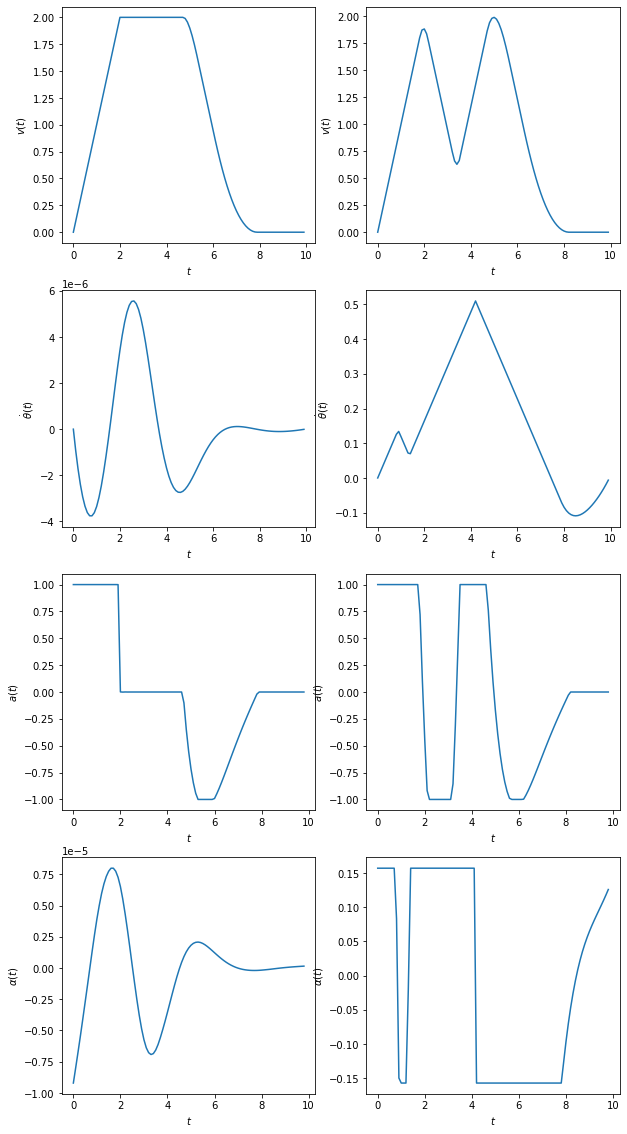

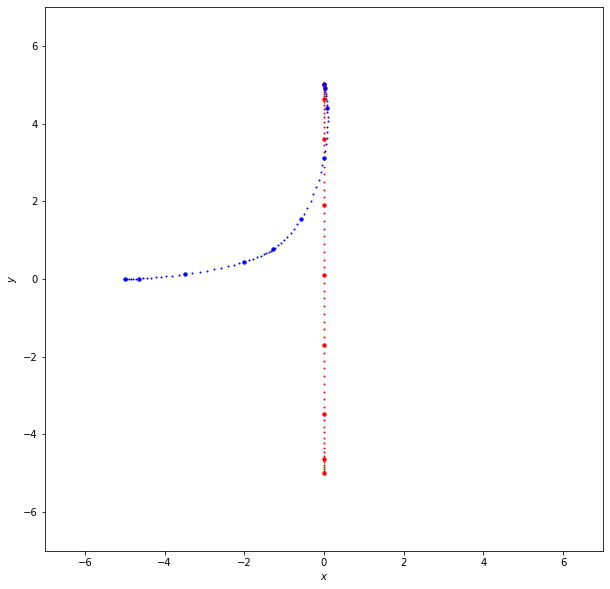

In [ ]:
    # Plot
    """
    fig, axes = plt.subplots(n+m+1, 2, figsize=(10,20))
    # plt.subplots_adjust(wspace=0.35)
    ylabels = (r'$x(t)$', r'$y(t)$', r'$\theta(t)$',
               r'$v(t)$', r'$\dot{\theta}(t)$',
               r'$a(t)$', r'$\alpha(t)$')
    # plt.fig()
    for a in range(agent):
        for i in range(n):
            axes[i, a].plot(t, s[a, :, i])
            axes[i, a].set_xlabel(r'$t$')
            axes[i, a].set_ylabel(ylabels[i])
        for j in range(m):
            axes[n+j, a].plot(t[0:N], u[a, :, j])
            axes[n+j, a].set_xlabel(r'$t$')
            axes[n+j, a].set_ylabel(ylabels[n+j])
        axes[-1, a].plot(s[a, :, 0], s[a, :, 1], 'o', markersize=1)
        axes[-1, a].plot(-1, 1, 'ko', markersize=1)
        axes[-1, a].set_xlabel(r'$x$')
        axes[-1, a].set_xlim([-7, 7])
        axes[-1, a].set_ylim([-7, 7])
        axes[-1, a].set_ylabel(r'$y$')
    locs = 10
    for n in range(locs):
        for a in range(agent):
            if a == 0:
                axes[-1, 0].plot(s[a, N//locs * n, 0], s[a, N//locs * n, 1], 'ro', markersize=3)
                axes[-1, 1].plot(s[a, N//locs * n, 0], s[a, N//locs * n, 1], 'ro', markersize=3)
            if a == 1:
                axes[-1, 0].plot(s[a, N//locs * n, 0], s[a, N//locs * n, 1], 'bo', markersize=3)
                axes[-1, 1].plot(s[a, N//locs * n, 0], s[a, N//locs * n, 1], 'bo', markersize=3)
    plt.savefig('intersection_two_left.png')
    # plt.show()
    """

    fig, axes = plt.subplots(n-3+m, 2, figsize=(10,20))
    # plt.subplots_adjust(wspace=0.35)
    ylabels = (r'$v(t)$', r'$\dot{\theta}(t)$',
               r'$a(t)$', r'$\alpha(t)$')
    # plt.fig()
    for a in range(agent):
        print(n)
        for i in range(n-3):
            print(3+i)
            axes[i, a].plot(t, s[a, :, 3+i])
            axes[i, a].set_xlabel(r'$t$')
            axes[i, a].set_ylabel(ylabels[i])
        for j in range(m):
            axes[n-3+j, a].plot(t[0:N], u[a, :, j])
            axes[n-3+j, a].set_xlabel(r'$t$')
            axes[n-3+j, a].set_ylabel(ylabels[n-3+j])
    plt.savefig('intersection_two_left.png')

    plt.figure(figsize=(10,10))
    for a in range(agent):
        if a == 0:
            plt.plot(s[a, :, 0], s[a, :, 1], 'ro', markersize=1)
        if a == 1:
            plt.plot(s[a, :, 0], s[a, :, 1], 'bo', markersize=1)
    plt.xlabel(r'$x$')
    plt.xlim([-7, 7])
    plt.ylim([-7, 7])
    plt.ylabel(r'$y$')
    locs = 10
    for l in range(locs):
        for a in range(agent):
            if a == 0:
                plt.plot(s[a, N//locs * l, 0], s[a, N//locs * l, 1], 'ro', markersize=3)
                plt.plot(s[a, N//locs * l, 0], s[a, N//locs * l, 1], 'ro', markersize=3)
            if a == 1:
                plt.plot(s[a, N//locs * l, 0], s[a, N//locs * l, 1], 'bo', markersize=3)
                plt.plot(s[a, N//locs * l, 0], s[a, N//locs * l, 1], 'bo', markersize=3)
    plt.savefig('intersection_two_left_traj.png')